The global pandemic has severely reduced peoples' mobility world-wide, as regional and national lock-downs and stay-at-home orders have gone into effect. In this post, I'll animate the impact that covid-19 has had on my daily commute/movements using my [Google Location History](https://support.google.com/accounts/answer/3118687?hl=en) data. Because I'm lucky enough to have a job that enabled me to work-from-home, and because my employer was proactive in putting us on work-from-home, I haven't been moving around too much since mid March. Around that point, the animation will get pretty boring. &#128578;

Althought there are many great utilities for plotting for location data in Python, such as [Folium](https://python-visualization.github.io/folium/) (which uses [Leaflet](https://leafletjs.com/)), I decided that I would rather stick to matplotlib based graphics to handle the animations. To make the plots more interesting, I will plot some shapefiles relevant to my commute/non-commute using [GeoPandas](https://geopandas.org/).


If you're not interested in the sausage-making process, and would rather just see the end result, you can <a href="#animation">click here</a> to jump straight to the animation.

The notebook for this post can be obtained [here](https://github.com/pkepley/blog-notebooks/blob/master/20200425_LocationData/LocationHistoryPlotting.ipynb). None of the datasets used in this notebook are provided.

## Importing the map data

In [1]:
from IPython.display import HTML
import tarfile
import json

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, date, timedelta
from multiprocessing import Pool

import sys, os

data_dir = os.path.join(os.path.expanduser('~'), 'Dropbox', 
                        'Projects', '20200424_PlottingCommutes')
sys.path.append(data_dir)


The following file contains the latitude and longitude of my home and work, which are saved in separate 2-dimensional arrays.

In [2]:
# My home and work location
from mydata import home_location, work_location

Next we import some Illinois datasets that we'll plot alongside my commute data. Specifically, we'll plot  highways, [Metra](https://metrarail.com/) lines, and Illinois' counties. 

Data were obtained from the following sources:
1. Illinois counties were obtained from the [Illinois Geospatial Data Clearinghouse](https://clearinghouse.isgs.illinois.edu/data/reference/illinois-county-boundaries-polygons-and-lines).
2. Metra lines were obtained from [data.gov](https://catalog.data.gov/dataset/metra-line).
3. Illinois roads were obtained from the Illinois Department of Transportation's [data portal](http://apps.dot.illinois.gov/gist2/), with data exported for 2019. In our plotting, we will only retain Cook/Lake county roads which are flagged as National Highway System roads. 

In [3]:
# Illinois counties shapefile.
# Source: https://clearinghouse.isgs.illinois.edu/data/reference/illinois-county-boundaries-polygons-and-lines
il_counties = gpd.read_file(os.path.join(data_dir, 'IL_BNDY_County', 'IL_BNDY_County_Py.shp'))
il_counties.to_crs('epsg:4326', inplace=True)

# Metra Lines
# Souce: https://catalog.data.gov/dataset/metra-line
metra_lines = gpd.read_file(os.path.join(data_dir, 'Metra_20Lines', 'MetraLinesshp.shp'))
metra_lines.to_crs('epsg:4326', inplace=True)

# Illinois roads shapefile. Only keep highways in Cook and Lake county
# Source: http://apps.dot.illinois.gov/gist2/
highways = gpd.read_file(os.path.join(data_dir, 'all2019', 'HWY2019.shp'))
highways = highways[(highways["COUNTY_NAM"] == 'COOK') | (highways["COUNTY_NAM"] == 'LAKE')]
highways.reindex()
highways = highways[highways['NHS'] == '1']
highways.reindex()
highways.to_crs('epsg:4326', inplace=True)


Before moving on, let's plot these datasets.

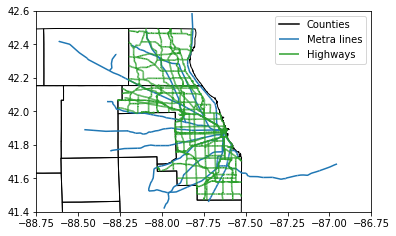

In [4]:
# Plot the metra lines and highways
fig,ax = plt.subplots()
metra_lines.plot(ax=ax, edgecolor='C0', label='Metra lines')
highways.plot(ax=ax, edgecolor='C2', label='Highways')
il_counties.plot(ax=ax, edgecolor='k', facecolor='None')
# following line is to label counties,  since it wasn't passing
# the label to the legend
plt.plot([],[],label='Counties', c='k')
ax.legend()
ax.set_xlim([-88.75, -86.75])
ax.set_ylim([ 41.40,  42.60])
plt.show()

## Prepping my location data

Next we grab my Google Loaction history data, which I exported from [Google Takeout](https://takeout.google.com/settings/takeout).

In [5]:
location_data_path = os.path.join(data_dir, 'takeout-20200422T042108Z-001.tgz')

tar = tarfile.open(location_data_path, 'r:gz')
location_file = tar.getmember('Takeout/Location History/Location History.json')
location_json_str = tar.extractfile(location_file).read()
location_json = json.loads(location_json_str)
location_json = location_json['locations']

del location_json_str

Google Location data is saved in Json with timestamps saved in millisecond accuracy, and latitude/longitude data saved to 7 digit accuracy in an integer form. We'll use the following function to  convert these data into more usable list records, and to only keep what we will need.

In [6]:
def parse_entry(e):
    date_time = datetime.fromtimestamp(np.int64(e['timestampMs']) / 1000)
    lat = e['latitudeE7'] / 10000000
    lon = e['longitudeE7'] / 10000000
    acc = e['accuracy']
    
    return [date_time, lat, lon, acc]    

As an example, here's a comparison of the original and parsed records.

In [7]:
print("original: ")
print(location_json[0])#, 'latitudeE7'])
print()
print("parsed: ")
print(parse_entry(location_json[0]))

original: 
{'timestampMs': '1392574064047', 'latitudeE7': 404543196, 'longitudeE7': -869305823, 'accuracy': 30, 'activity': [{'timestampMs': '1392573944827', 'activity': [{'type': 'STILL', 'confidence': 100}]}, {'timestampMs': '1392574034053', 'activity': [{'type': 'ON_FOOT', 'confidence': 40}, {'type': 'UNKNOWN', 'confidence': 38}, {'type': 'IN_VEHICLE', 'confidence': 10}, {'type': 'STILL', 'confidence': 10}]}]}

parsed: 
[datetime.datetime(2014, 2, 16, 12, 7, 44, 47000), 40.4543196, -86.9305823, 30]


Since there are a lot of records, we'll use multiprocessing to quickly parse the entire Json file.

In [8]:
with Pool(2) as p:
    location_data = p.map(parse_entry, location_json)

Next we store the records in a Pandas dataframe.

In [9]:
df_location = pd.DataFrame(location_data, columns=['date_time', 'lat', 'lon', 'acc'])
df_location = df_location.set_index('date_time')
df_location = df_location.sort_index()
df_location = df_location.reset_index()
df_location.head()

,date_time,lat,lon,acc
0,2014-02-16 12:07:44.047,40.454320,-86.930582,30
1,2014-02-16 12:08:44.103,40.454320,-86.930582,30
2,2014-02-16 12:09:44.369,40.454320,-86.930582,30
3,2014-02-16 12:10:34.335,40.454320,-86.930582,30
4,2014-02-16 12:11:39.967,40.434673,-86.916522,1880


We only want to plot location records that are reasonably accurate, since low-accuracy data points can be way off. The following table shows summary stats for the accuracy by calendar year. We'll use this to select an upper-bound on location accuracy for plotting.

In [10]:
df_location.groupby(df_location.date_time.dt.year)[['acc']].describe()

acc                                                        \
              count         mean           std  min   25%     50%     75%   
date_time                                                                   
2014        49742.0  1407.214205   1158.727045  3.0  39.0  1722.0  2573.0   
2015       241712.0   357.541872    743.411443  3.0  30.0    40.0    73.0   
2016       109353.0    87.264062    339.972851  0.0   8.0    19.0    25.0   
2017       162874.0    35.880097    161.729510  0.0   4.0    17.0    20.0   
2018       267653.0    35.902022    169.888784  0.0  10.0    13.0    16.0   
2019       257062.0   181.374832  10614.297563  3.0   3.0    13.0    15.0   
2020        45921.0    47.517563    185.336730  3.0  13.0    14.0    17.0   

                      
                 max  
date_time             
2014          8436.0  
2015          9564.0  
2016          9764.0  
2017          6550.0  
2018         19423.0  
2019       1780762.0  
2020          8435.0

in 2020, 75% of my location records had an accuracy of 17 or lower. We'll be a bit conservative and use 30 as an upper bound.

## Animating my commute / non-commute

First we define a class which will basically just serve as a structure to hold components of the animation.

In [11]:
class animation_class:
    def __init__(self, df_location, start_date, end_date, interval_in_hours, figsize=None, fontsize=12):            
        self.start_date = start_date
        self.end_date = end_date
        self.interval_in_hours = interval_in_hours
        self.figsize = figsize
        self.fontsize = fontsize
        
        self.df_location = df_location[(df_location['date_time'] >= start_date.strftime('%Y-%m-%d')) & 
                            (df_location['date_time'] <= end_date.strftime('%Y-%m-%d')) &
                            (df_location['acc'] < 30)]                
               
        # Set up the plot elements
        if figsize is not None:
            self.fig, self.ax = plt.subplots()        
        else:
            self.fig, self.ax = plt.subplots(figsize = figsize)        
        
        # Set up range and equal aspect
        self.ax.set_xlim(self.df_location.lon.min(), self.df_location.lon.max())        
        self.ax.set_ylim(self.df_location.lat.min(), self.df_location.lat.max())
        self.ax.set_aspect('equal')        
        
        # Set up scatter 
        self.scat = self.ax.scatter([],[], c = 'C3')

    def get_date_range(self, i):
        range_start = datetime.combine(start_date, datetime.min.time()) + timedelta(hours=self.interval_in_hours * i)                         
        range_end = range_start + timedelta(hours=self.interval_in_hours * 1)

        return range_start, range_end
        
    def get_df_range(self, i):
        range_start, range_end = self.get_date_range(i)
        
        df_range = self.df_location[(self.df_location['date_time'] >= range_start) & 
                            (self.df_location['date_time'] < range_end) &
                            (self.df_location['acc'] < 30)]
        
        return df_range
    
    def init(self):        
        self.scat = self.anim(i = 0)
        
        # My work and home
        self.ax.text(home_location[1], home_location[0], 'HOME', fontsize=self.fontsize, weight='bold')
        self.ax.text(work_location[1], work_location[0], 'WORK', fontsize=self.fontsize, weight='bold')

        # Plot the metra rail lines, highways, and illinois counties
        metra_lines.plot(ax = self.ax, edgecolor='C0')       
        highways.plot(ax = self.ax,    edgecolor = 'C2')
        il_counties.plot(ax = self.ax, edgecolor='k', facecolor='None')
        
        return self.scat
            
    def anim(self, i = 0):
        range_start, range_end = self.get_date_range(i)
        
        df_range = self.get_df_range(i)        
    
        self.scat.set_offsets(df_range[['lon', 'lat']])
        

        self.ax.set_title('{}'.format(range_start.strftime('%a %d %b %Y %H:%M')))
                
        return self.scat

Next we set-up the animation. We'll only plot data from 2020, bucketed into 4 hour increments. The last available date in the dataset is April 21<sup>st</sup>.

In [12]:
start_date = date(2020, 1, 1)
end_date   = date(2020, 4, 21)
date_delta = end_date - start_date
n_days = date_delta.days + 1

ac = animation_class(df_location, start_date, end_date, 
                     interval_in_hours=4,
                     figsize=(10,10),
                     fontsize=16)

ani = animation.FuncAnimation(ac.fig,
                              ac.anim,
                              init_func=ac.init,
                              frames=(24 // ac.interval_in_hours) * n_days,
                              interval = 1000 // (24 // ac.interval_in_hours), 
                              blit = False,
                              repeat=True);
plt.close()

## Animation <a id="animation"></a>

Finally, here's the animation. If animation doesn't show up, try clicking in the cell below to engage the controls.

In [13]:
HTML(ani.to_html5_video())